#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import seaborn as sns
import sklearn
import optuna 
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm.notebook import tqdm # this module is useful to plot progress bars
import pathlib
import plotly
import imageio
import gc

import torch
import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch import nn

from optuna.trial import TrialState

In [2]:
### Set the random seed for reproducible results
torch.manual_seed(753)
np.random.seed(753)

# MNIST dataset

In [3]:
### Download the data and create dataset
data_dir = 'dataset'

# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

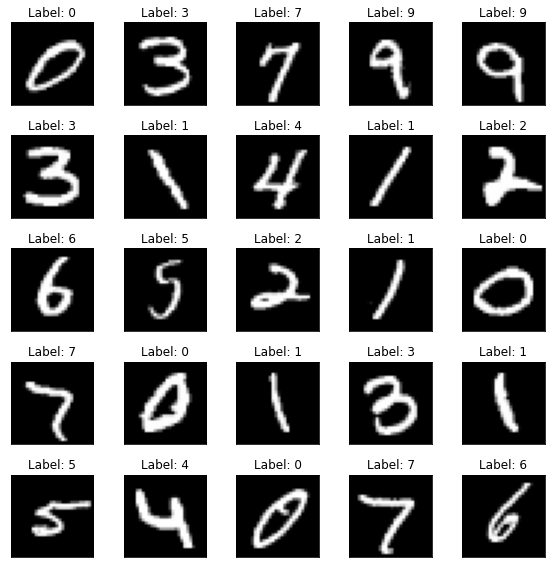

In [4]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In [5]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

# Data Loader

In [6]:
#divide in training an validation dataset with percentage 80%-20%

TRAIN_PERC = 0.8
TRAIN_ELEM = len(train_dataset)
N_TRAIN_ELEM = int(TRAIN_ELEM*TRAIN_PERC) 
N_VALID_ELEM = TRAIN_ELEM - N_TRAIN_ELEM
N_TEST_ELEM  = len(test_dataset)

print("Elements in Train set:",      N_TRAIN_ELEM)
print("Elements in Validation set:", N_VALID_ELEM)
print("Elements in Test set:",       N_TEST_ELEM )

# Prepare Training and Validation sets
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [N_TRAIN_ELEM, N_VALID_ELEM])

Elements in Train set: 48000
Elements in Validation set: 12000
Elements in Test set: 10000


In [7]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define validation dataloader
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# The model

### Encoder

In [8]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim = 2, n_channels = 8):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels = 1,  out_channels = n_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(n_channels, 2*n_channels, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(2*n_channels, 4*n_channels, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 4*n_channels, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

### Decoder

In [9]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim = 2, n_channels = 8):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 4*n_channels),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(4*n_channels, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(4*n_channels, 2*n_channels, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(2*n_channels, n_channels, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(n_channels, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [10]:
### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim, n_channels = 8)
decoder = Decoder(encoded_space_dim=encoded_space_dim, n_channels = 8)

In [11]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


## Training

In [12]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [13]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
        
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Define the lists to store the outputs for each batch
    conc_out = []
    conc_label = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append the network output and the original image to the lists
        conc_out.append(decoded_data.cpu())
        conc_label.append(image_batch.cpu())
        
    # Create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label)
    # Evaluate global loss
    train_loss = loss_fn(conc_out, conc_label)  
    
    #return the training loss
    return train_loss.data

In [14]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss.data

In [15]:
def training(encoder, decoder, train_loader, valid_loader, params_dict, valid_dataset = None,
             plot_progress = False, save_output = False, save_checkpoint = False):
    
    '''
    This function runs the training of the network for a certain number of epoch. The training and validation steps
    are taken from the two single functions defined earlier.
    ======================  INPUT  ==================================
    encoder          : encoder to be trained
    decoder          : decoder to be trained
    train_loader     : dataloader with training data
    valid_loader     : dataloader with validation/test data
    params_dict      : dictionary with parameters needed such as -> device, number of epochs, loss, optimizer
    valid_dataset    : dataset with test/validation data needed to plot reconstructed image
    plot_progress    : whether to show images as pairs (original, reconstructed) for every epoch
    save_output      : whether to save images as pairs (original, reconstructed) for every epoch
    save_checkpoint  : whether to save checkpoints for the encoder, decoder and optimizer to resume training
    
    ======================  OUTPUT  =================================
    train_losses_list: list of average training losses over the batches and for every epoch  
    valid_losses_list: list of avalidation losses for every epoch  
    img_list         : list of reconstructed images, present only if plot_progress is True
    
    '''
    
    img_list = []
    
    valid_losses_list = []
    train_losses_list = []
    
    optim  = params_dict.get('optimizer')
    loss       = params_dict.get('loss')
    
    
    for epoch in tqdm(range(params_dict.get('n_epochs'))):

        ### Training (use the training function)
        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=params_dict.get('device'), 
            dataloader=train_loader, 
            loss_fn=loss, 
            optimizer=optim)
        train_losses_list.append(train_loss)

        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=params_dict.get('device'), 
            dataloader=valid_loader, 
            loss_fn=loss)
        valid_losses_list.append(val_loss)

        if (plot_progress)|(save_output):
            img = valid_dataset[0][0].unsqueeze(0).to(params_dict.get('device'))
            encoder.eval()
            decoder.eval()

            with torch.no_grad():
                rec_img  = decoder(encoder(img))

            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(12,6))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()

            if (plot_progress):
            # Show figures
                plt.show()
            if (save_output):
            # Save figures
                os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
                fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))

            plt.close()
            img_list.append(rec_img.cpu().squeeze().numpy())
            
        else:
            img_list.append(None)

        if (save_checkpoint):
            # Save network parameters
            torch.save(encoder.state_dict(),   'encoder_params.pth')
            torch.save(decoder.state_dict(),   'decoder_params.pth')
            torch.save(optim.state_dict(),     'optim_params.pth')

    return train_losses_list, valid_losses_list, img_list


In [16]:
def plot_array_rec_images(img_list, target = None):
    tot_images = len(img_list)
    
    n_cols = 8
    
    if tot_images%8 == 0:
        n_rows = tot_images//8
    else:
        n_rows = tot_images//8 + 1
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize = (10, 10))
    for i, img in enumerate(img_list):
        row = i//n_cols
        col = i%n_cols
        ax[row,col].imshow(img, cmap='gist_gray')
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title("Epoch "+str(i+1))
    plt.tight_layout()
    plt.show()
    
    return

### Test a network

In [17]:
### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim, n_channels = 8)
decoder = Decoder(encoded_space_dim=encoded_space_dim, n_channels = 8)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

def_params_dict = {
    "device"    : device,
    "n_epochs"  : 40,
    "loss"      : loss_fn,
    "optimizer" : optim,
}

In [18]:
tr_loss, valid_loss, rec_img_list = training(encoder, decoder, 
                                             train_dataloader, test_dataloader, 
                                             def_params_dict, test_dataset,
                                             plot_progress = False, save_output = True, save_checkpoint = False)

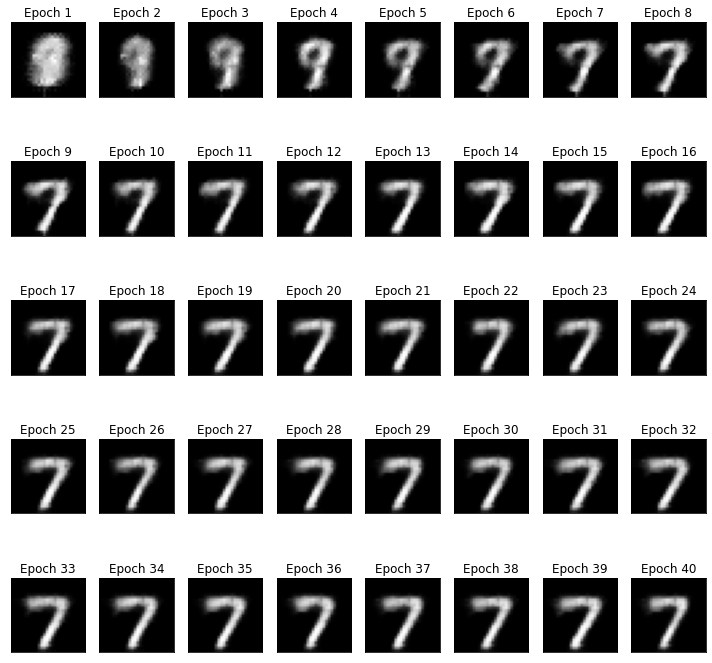

In [19]:
plot_array_rec_images(rec_img_list)

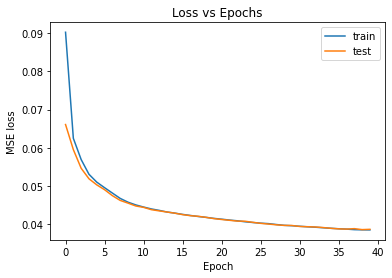

In [20]:
plt.plot(np.array(tr_loss), label = 'train')
plt.plot(np.array(valid_loss), label = 'test')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

### Hyperparameter optimization

We are going to use OPTUNA (see [github](https://github.com/optuna/optuna), [ref](https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36), [example](https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py)) in order to make the hyperparameter optimization run faster.

Moreover it was chosen to **not** implement the Cross Validation using k-folds, since the data is quite large and we have seen in the previous homework that overfitting is really unlikely.

In [21]:
def Optuna_create_model(trial):
    
    n_chan = trial.suggest_int("n_channels", 4, 12)
    feature_dim = trial.suggest_int("encoded_space_dim", 2, 10)
    
    encoder = Encoder(encoded_space_dim=feature_dim, n_channels = n_chan)
    decoder = Decoder(encoded_space_dim=feature_dim, n_channels = n_chan)
    
    return nn.Sequential(encoder, decoder)


In [22]:
MAX_EPOCHS = 40

def objective(trial):

    # Generate the model.
    model = Optuna_create_model(trial).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) 
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e0, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay = weight_decay )

    # Get the dataset.
    train_loader, valid_loader = train_dataloader, validation_dataloader

    # Training of the model.
    for epoch in tqdm(range(MAX_EPOCHS)):
        
        ############################# TRAINING STEP ###################################
        
        # Set train mode
        model.train()

        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for image_batch, _ in train_loader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            output = model(image_batch)
            
            # Evaluate loss
            optimizer.zero_grad()
            loss = loss_fn(output, image_batch)
            # Backward pass
            loss.backward()
            optimizer.step()
        
        ############################# VALIDATION STEP ###################################
        
        # Set evaluation mode
        model.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_out = []
            conc_label = []
            for image_batch, _ in valid_loader:
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                output = model(image_batch)

                # Append the network output and the original image to the lists
                conc_out.append(output.cpu())
                conc_label.append(image_batch.cpu())

            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
        
        trial.report(val_loss.data, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

In [23]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())

[I 2021-08-30 20:35:29,763] A new study created in memory with name: no-name-55529de4-7781-4977-948b-51361247ad33


In [24]:
study.optimize(objective, n_trials = 100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

[I 2021-08-30 20:43:42,626] Trial 0 finished with value: 0.11300262808799744 and parameters: {'n_channels': 10, 'encoded_space_dim': 4, 'optimizer': 'SGD', 'lr': 0.01687948202133754, 'weight_decay': 0.050902219193161936}. Best is trial 0 with value: 0.11300262808799744.


[I 2021-08-30 20:52:31,601] Trial 1 finished with value: 0.09918292611837387 and parameters: {'n_channels': 12, 'encoded_space_dim': 10, 'optimizer': 'SGD', 'lr': 0.03756341496807123, 'weight_decay': 0.013885315405727175}. Best is trial 1 with value: 0.09918292611837387.


[I 2021-08-30 21:00:52,431] Trial 2 finished with value: 0.09680788964033127 and parameters: {'n_channels': 10, 'encoded_space_dim': 10, 'optimizer': 'RMSprop', 'lr': 0.03918391048561502, 'weight_decay': 0.007534163731939426}. Best is trial 2 with value: 0.09680788964033127.


[I 2021-08-30 21:07:44,117] Trial 3 finished with value: 0.19425973296165466 and parameters: {'n_channels': 5, 'encoded_space_dim': 8, 'optimizer': 'RMSprop', 'lr': 0.00129611827362446, 'weight_decay': 0.7032805364083082}. Best is trial 2 with value: 0.09680788964033127.


[I 2021-08-30 21:13:34,138] Trial 4 finished with value: 0.16659876704216003 and parameters: {'n_channels': 4, 'encoded_space_dim': 10, 'optimizer': 'RMSprop', 'lr': 0.0006089883729029767, 'weight_decay': 0.3090188109699115}. Best is trial 2 with value: 0.09680788964033127.


[I 2021-08-30 21:13:42,858] Trial 5 pruned. 


[I 2021-08-30 21:13:52,953] Trial 6 pruned. 


[I 2021-08-30 21:14:33,047] Trial 7 pruned. 


[I 2021-08-30 21:14:44,893] Trial 8 pruned. 


[I 2021-08-30 21:15:01,088] Trial 9 pruned. 


[I 2021-08-30 21:15:11,681] Trial 10 pruned. 


[I 2021-08-30 21:21:24,044] Trial 11 finished with value: 0.09630332887172699 and parameters: {'n_channels': 8, 'encoded_space_dim': 8, 'optimizer': 'SGD', 'lr': 0.06304676358970589, 'weight_decay': 0.0054406045741078315}. Best is trial 11 with value: 0.09630332887172699.


[I 2021-08-30 21:27:32,841] Trial 12 finished with value: 0.09537731856107712 and parameters: {'n_channels': 8, 'encoded_space_dim': 8, 'optimizer': 'SGD', 'lr': 0.07144146953036651, 'weight_decay': 0.0014298261207753887}. Best is trial 12 with value: 0.09537731856107712.


[I 2021-08-30 21:33:30,995] Trial 13 finished with value: 0.09519445896148682 and parameters: {'n_channels': 7, 'encoded_space_dim': 8, 'optimizer': 'SGD', 'lr': 0.09273812545757881, 'weight_decay': 0.0005586038324642176}. Best is trial 13 with value: 0.09519445896148682.


[I 2021-08-30 21:33:39,954] Trial 14 pruned. 


[I 2021-08-30 21:39:38,799] Trial 15 finished with value: 0.09504047781229019 and parameters: {'n_channels': 7, 'encoded_space_dim': 8, 'optimizer': 'SGD', 'lr': 0.09522642062893442, 'weight_decay': 0.00043404951608006415}. Best is trial 15 with value: 0.09504047781229019.


[I 2021-08-30 21:39:47,235] Trial 16 pruned. 


[I 2021-08-30 21:39:56,223] Trial 17 pruned. 


[I 2021-08-30 21:40:04,802] Trial 18 pruned. 


[I 2021-08-30 21:40:15,109] Trial 19 pruned. 


[I 2021-08-30 21:45:53,084] Trial 20 finished with value: 0.09549476206302643 and parameters: {'n_channels': 6, 'encoded_space_dim': 9, 'optimizer': 'SGD', 'lr': 0.09656589184466058, 'weight_decay': 0.0021504367323947624}. Best is trial 15 with value: 0.09504047781229019.


[I 2021-08-30 21:46:02,479] Trial 21 pruned. 


[I 2021-08-30 21:46:12,824] Trial 22 pruned. 


[I 2021-08-30 21:52:20,412] Trial 23 finished with value: 0.09511959552764893 and parameters: {'n_channels': 8, 'encoded_space_dim': 7, 'optimizer': 'SGD', 'lr': 0.09735844054203154, 'weight_decay': 0.0002735846705964363}. Best is trial 15 with value: 0.09504047781229019.


[I 2021-08-30 21:58:19,490] Trial 24 finished with value: 0.09517213702201843 and parameters: {'n_channels': 7, 'encoded_space_dim': 7, 'optimizer': 'SGD', 'lr': 0.09719176423016816, 'weight_decay': 2.9236344989433996e-05}. Best is trial 15 with value: 0.09504047781229019.


[I 2021-08-30 22:09:10,673] Trial 25 finished with value: 0.02765806019306183 and parameters: {'n_channels': 8, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.0185837160094604, 'weight_decay': 2.0770630526133634e-05}. Best is trial 25 with value: 0.02765806019306183.


[I 2021-08-30 22:17:59,193] Trial 26 finished with value: 0.027301069349050522 and parameters: {'n_channels': 8, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.01693938212058079, 'weight_decay': 1.020995637802289e-05}. Best is trial 26 with value: 0.027301069349050522.


[I 2021-08-30 22:27:05,677] Trial 27 finished with value: 0.026824744418263435 and parameters: {'n_channels': 10, 'encoded_space_dim': 4, 'optimizer': 'Adam', 'lr': 0.003382597539847745, 'weight_decay': 1.3053234864896769e-05}. Best is trial 27 with value: 0.026824744418263435.


[I 2021-08-30 22:27:23,323] Trial 28 pruned. 


[I 2021-08-30 22:36:59,797] Trial 29 finished with value: 0.030795706436038017 and parameters: {'n_channels': 11, 'encoded_space_dim': 4, 'optimizer': 'Adam', 'lr': 0.019164337282183915, 'weight_decay': 2.917731095804129e-05}. Best is trial 27 with value: 0.026824744418263435.


[I 2021-08-30 22:46:37,649] Trial 30 finished with value: 0.024729132652282715 and parameters: {'n_channels': 9, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.009593562279174158, 'weight_decay': 2.4569831637653783e-05}. Best is trial 30 with value: 0.024729132652282715.


[I 2021-08-30 22:46:51,357] Trial 31 pruned. 


[I 2021-08-30 22:58:38,531] Trial 32 finished with value: 0.024353627115488052 and parameters: {'n_channels': 11, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.004179601199663037, 'weight_decay': 2.8011563282964956e-05}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-30 23:06:43,197] Trial 33 finished with value: 0.03447628393769264 and parameters: {'n_channels': 11, 'encoded_space_dim': 3, 'optimizer': 'Adam', 'lr': 0.004332478608759091, 'weight_decay': 7.280362565411422e-05}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-30 23:18:35,473] Trial 34 finished with value: 0.026204969733953476 and parameters: {'n_channels': 10, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.007918178948875289, 'weight_decay': 4.2225183047651746e-05}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-30 23:28:41,834] Trial 35 finished with value: 0.033563364297151566 and parameters: {'n_channels': 10, 'encoded_space_dim': 3, 'optimizer': 'Adam', 'lr': 0.0021255581316344534, 'weight_decay': 3.8506424158417015e-05}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-30 23:37:50,187] Trial 36 finished with value: 0.025630448013544083 and parameters: {'n_channels': 11, 'encoded_space_dim': 6, 'optimizer': 'Adam', 'lr': 0.008076032168509682, 'weight_decay': 0.0001469838846454506}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-30 23:46:43,239] Trial 37 finished with value: 0.025409294292330742 and parameters: {'n_channels': 11, 'encoded_space_dim': 6, 'optimizer': 'Adam', 'lr': 0.007152910830948999, 'weight_decay': 0.0001280815285752019}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-30 23:58:06,033] Trial 38 finished with value: 0.05965833738446236 and parameters: {'n_channels': 11, 'encoded_space_dim': 6, 'optimizer': 'Adam', 'lr': 0.0003766809193010001, 'weight_decay': 0.0001568743383362107}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-30 23:58:18,467] Trial 39 pruned. 


[I 2021-08-31 00:06:21,729] Trial 40 finished with value: 0.04439719021320343 and parameters: {'n_channels': 11, 'encoded_space_dim': 6, 'optimizer': 'Adam', 'lr': 0.030816013931664697, 'weight_decay': 0.0001174594439183591}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-31 00:16:32,860] Trial 41 finished with value: 0.026934603229165077 and parameters: {'n_channels': 10, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.007350747264812984, 'weight_decay': 6.337803407756837e-05}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-31 00:27:02,286] Trial 42 finished with value: 0.02508370950818062 and parameters: {'n_channels': 11, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.01022117401691182, 'weight_decay': 2.4061856334258514e-05}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-31 00:27:31,781] Trial 43 pruned. 


[I 2021-08-31 00:38:30,440] Trial 44 finished with value: 0.031092075631022453 and parameters: {'n_channels': 11, 'encoded_space_dim': 4, 'optimizer': 'Adam', 'lr': 0.003810642651287946, 'weight_decay': 0.00010220528599078269}. Best is trial 32 with value: 0.024353627115488052.


[I 2021-08-31 00:38:47,537] Trial 45 pruned. 


[I 2021-08-31 00:47:54,232] Trial 46 finished with value: 0.02313324436545372 and parameters: {'n_channels': 11, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.0027137666113234327, 'weight_decay': 2.0274327864996294e-05}. Best is trial 46 with value: 0.02313324436545372.


[I 2021-08-31 00:48:05,592] Trial 47 pruned. 


[I 2021-08-31 00:57:19,482] Trial 48 finished with value: 0.024251867085695267 and parameters: {'n_channels': 11, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.003200338501943763, 'weight_decay': 4.164951952756774e-05}. Best is trial 46 with value: 0.02313324436545372.


[I 2021-08-31 00:57:31,683] Trial 49 pruned. 


[I 2021-08-31 00:57:42,720] Trial 50 pruned. 


[I 2021-08-31 00:58:14,953] Trial 51 pruned. 


[I 2021-08-31 01:08:29,157] Trial 52 finished with value: 0.023351818323135376 and parameters: {'n_channels': 11, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.005193862038393925, 'weight_decay': 1.7357954886024482e-05}. Best is trial 46 with value: 0.02313324436545372.


[I 2021-08-31 01:21:06,782] Trial 53 finished with value: 0.027645422145724297 and parameters: {'n_channels': 12, 'encoded_space_dim': 4, 'optimizer': 'Adam', 'lr': 0.00526472020910347, 'weight_decay': 1.972362333763563e-05}. Best is trial 46 with value: 0.02313324436545372.


[I 2021-08-31 01:21:18,609] Trial 54 pruned. 


[I 2021-08-31 01:21:37,570] Trial 55 pruned. 


[I 2021-08-31 01:21:55,628] Trial 56 pruned. 


[I 2021-08-31 01:33:16,207] Trial 57 finished with value: 0.03005121275782585 and parameters: {'n_channels': 11, 'encoded_space_dim': 4, 'optimizer': 'Adam', 'lr': 0.002401951017624019, 'weight_decay': 7.413017192235902e-05}. Best is trial 46 with value: 0.02313324436545372.


[I 2021-08-31 01:45:28,675] Trial 58 finished with value: 0.025576770305633545 and parameters: {'n_channels': 12, 'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.011216227177410673, 'weight_decay': 2.4731863703713795e-05}. Best is trial 46 with value: 0.02313324436545372.


[I 2021-08-31 01:45:39,681] Trial 59 pruned. 


[I 2021-08-31 01:45:52,332] Trial 60 pruned. 


[I 2021-08-31 01:55:21,057] Trial 61 finished with value: 0.021878454834222794 and parameters: {'n_channels': 11, 'encoded_space_dim': 6, 'optimizer': 'Adam', 'lr': 0.00511001966654271, 'weight_decay': 3.58711054169893e-05}. Best is trial 61 with value: 0.021878454834222794.


[I 2021-08-31 02:05:36,431] Trial 62 finished with value: 0.02182641625404358 and parameters: {'n_channels': 11, 'encoded_space_dim': 6, 'optimizer': 'Adam', 'lr': 0.005548451687338438, 'weight_decay': 3.1405061450193656e-05}. Best is trial 62 with value: 0.02182641625404358.


[I 2021-08-31 02:16:28,391] Trial 63 finished with value: 0.021845810115337372 and parameters: {'n_channels': 11, 'encoded_space_dim': 6, 'optimizer': 'Adam', 'lr': 0.005327678907459428, 'weight_decay': 3.570609699649729e-05}. Best is trial 62 with value: 0.02182641625404358.


[I 2021-08-31 02:16:36,020] Trial 64 pruned. 


[I 2021-08-31 02:16:52,595] Trial 65 pruned. 


[I 2021-08-31 02:17:19,200] Trial 66 pruned. 


[I 2021-08-31 02:17:31,060] Trial 67 pruned. 


[I 2021-08-31 02:17:42,769] Trial 68 pruned. 


[I 2021-08-31 02:25:52,943] Trial 69 finished with value: 0.017711473628878593 and parameters: {'n_channels': 11, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.0012125920737865654, 'weight_decay': 1.0579117104531179e-05}. Best is trial 69 with value: 0.017711473628878593.


[I 2021-08-31 02:26:04,246] Trial 70 pruned. 


[I 2021-08-31 02:36:03,672] Trial 71 finished with value: 0.017974553629755974 and parameters: {'n_channels': 11, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.005195222064603636, 'weight_decay': 1.4227904633635369e-05}. Best is trial 69 with value: 0.017711473628878593.


[I 2021-08-31 02:36:20,731] Trial 72 pruned. 


[I 2021-08-31 02:36:32,118] Trial 73 pruned. 


[I 2021-08-31 02:47:39,185] Trial 74 finished with value: 0.021111106500029564 and parameters: {'n_channels': 11, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.0142348083599629, 'weight_decay': 3.6952267330954284e-05}. Best is trial 69 with value: 0.017711473628878593.


[I 2021-08-31 02:56:23,519] Trial 75 finished with value: 0.017440570518374443 and parameters: {'n_channels': 12, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.002218297236988399, 'weight_decay': 1.010395281051681e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 03:06:40,625] Trial 76 finished with value: 0.02268068492412567 and parameters: {'n_channels': 12, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.015321180213687263, 'weight_decay': 5.909799858930361e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 03:18:34,365] Trial 77 finished with value: 0.022723855450749397 and parameters: {'n_channels': 12, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.013879516299920699, 'weight_decay': 3.3511881555708455e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 03:18:46,212] Trial 78 pruned. 


[I 2021-08-31 03:19:10,427] Trial 79 pruned. 


[I 2021-08-31 03:19:22,302] Trial 80 pruned. 


[I 2021-08-31 03:29:03,236] Trial 81 finished with value: 0.021738378331065178 and parameters: {'n_channels': 12, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.014182986270805274, 'weight_decay': 3.311841799240102e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 03:45:44,097] Trial 82 finished with value: 0.01998046785593033 and parameters: {'n_channels': 12, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.014769910864793808, 'weight_decay': 1.309168088726738e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 03:45:56,864] Trial 83 pruned. 


[I 2021-08-31 03:56:39,305] Trial 84 finished with value: 0.022263508290052414 and parameters: {'n_channels': 12, 'encoded_space_dim': 8, 'optimizer': 'Adam', 'lr': 0.02987546099612256, 'weight_decay': 1.3950436852548297e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 04:06:40,376] Trial 85 finished with value: 0.025125345215201378 and parameters: {'n_channels': 12, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.03925989533827218, 'weight_decay': 3.1412296602571785e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 04:16:19,653] Trial 86 finished with value: 0.018461840227246284 and parameters: {'n_channels': 11, 'encoded_space_dim': 9, 'optimizer': 'Adam', 'lr': 0.01819453752108593, 'weight_decay': 2.2891251149341393e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 04:16:33,704] Trial 87 pruned. 


[I 2021-08-31 04:16:46,745] Trial 88 pruned. 


[I 2021-08-31 04:17:00,012] Trial 89 pruned. 


[I 2021-08-31 04:17:08,096] Trial 90 pruned. 


[I 2021-08-31 04:27:51,042] Trial 91 finished with value: 0.024361884221434593 and parameters: {'n_channels': 11, 'encoded_space_dim': 6, 'optimizer': 'Adam', 'lr': 0.008721785543298955, 'weight_decay': 9.187838909091766e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 04:37:38,725] Trial 92 finished with value: 0.02242950163781643 and parameters: {'n_channels': 11, 'encoded_space_dim': 7, 'optimizer': 'Adam', 'lr': 0.01762522587755288, 'weight_decay': 4.0845796960417926e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 04:37:55,611] Trial 93 pruned. 


[I 2021-08-31 04:38:19,467] Trial 94 pruned. 


[I 2021-08-31 04:38:35,156] Trial 95 pruned. 


[I 2021-08-31 04:48:41,983] Trial 96 finished with value: 0.021703068166971207 and parameters: {'n_channels': 10, 'encoded_space_dim': 8, 'optimizer': 'Adam', 'lr': 0.025783089489867614, 'weight_decay': 1.282672965427459e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 05:00:35,572] Trial 97 finished with value: 0.021756090223789215 and parameters: {'n_channels': 10, 'encoded_space_dim': 8, 'optimizer': 'Adam', 'lr': 0.025169262694257354, 'weight_decay': 1.3539067885097399e-05}. Best is trial 75 with value: 0.017440570518374443.


[I 2021-08-31 05:00:47,589] Trial 98 pruned. 


[I 2021-08-31 05:11:15,716] Trial 99 finished with value: 0.023820333182811737 and parameters: {'n_channels': 10, 'encoded_space_dim': 8, 'optimizer': 'Adam', 'lr': 0.02721657976290326, 'weight_decay': 2.231025803142464e-05}. Best is trial 75 with value: 0.017440570518374443.



Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  47
  Number of complete trials:  53


In [25]:
optimization_dir = 'optimization'
pathlib.Path('optimization').mkdir(parents=True, exist_ok=True) 

trials_df = study.trials_dataframe()
trials_df.to_csv(optimization_dir + '/optuna_results.csv')

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
opt_network_dictionary = {}
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value)) 
    opt_network_dictionary.update({key:value})
trials_df

Best trial:
  Value:  0.017440570518374443
  Params: 
    n_channels: 12
    encoded_space_dim: 7
    optimizer: Adam
    lr: 0.002218297236988399
    weight_decay: 1.010395281051681e-05


number     value             datetime_start          datetime_complete  \
0        0  0.113003 2021-08-30 20:35:29.770319 2021-08-30 20:43:42.626209   
1        1  0.099183 2021-08-30 20:43:42.627580 2021-08-30 20:52:31.600484   
2        2  0.096808 2021-08-30 20:52:31.601896 2021-08-30 21:00:52.431469   
3        3  0.194260 2021-08-30 21:00:52.432822 2021-08-30 21:07:44.117217   
4        4  0.166599 2021-08-30 21:07:44.118778 2021-08-30 21:13:34.138347   
..     ...       ...                        ...                        ...   
95      95  0.086638 2021-08-31 04:38:19.468452 2021-08-31 04:38:35.156554   
96      96  0.021703 2021-08-31 04:38:35.157582 2021-08-31 04:48:41.982791   
97      97  0.021756 2021-08-31 04:48:41.984573 2021-08-31 05:00:35.571723   
98      98  0.068808 2021-08-31 05:00:35.573265 2021-08-31 05:00:47.589623   
99      99  0.023820 2021-08-31 05:00:47.590642 2021-08-31 05:11:15.715799   

                 duration  params_encoded_space_dim  params_lr  \
0  0 days 00:08:12.855890                         4   0.016879   
1  0 days 00:08:48.972904                        10   0.037563   
2  0 days 00:08:20.829573                        10   0.039184   
3  0 days 00:06:51.684395                         8   0.001296   
4  0 days 00:05:50.019569                        10   0.000609   
..                    ...                       ...        ...   
95 0 days 00:00:15.688102                         6   0.010810   
96 0 days 00:10:06.825209                         8   0.025783   
97 0 days 00:11:53.587150                         8   0.025169   
98 0 days 00:00:12.016358                         8   0.051700   
99 0 days 00:10:28.125157                         8   0.027217   

    params_n_channels params_optimizer  params_weight_decay     state  
0                  10              SGD             0.050902  COMPLETE  
1                  12              SGD             0.013885  COMPLETE  
2                  10          RMSprop             0.007534  COMPLETE  
3                   5          RMSprop             0.703281  COMPLETE  
4                   4          RMSprop             0.309019  COMPLETE  
..                ...              ...                  ...       ...  
95                 12             Adam             0.000018    PRUNED  
96                 10             Adam             0.000013  COMPLETE  
97                 10             Adam             0.000014  COMPLETE  
98                 10             Adam             0.000013    PRUNED  
99                 10             Adam             0.000022  COMPLETE  

[100 rows x 11 columns]

In [26]:
optuna.visualization.plot_optimization_history(study, target_name = 'Validation loss' )

In [27]:
optuna.visualization.plot_intermediate_values(study)

In [28]:
optuna.visualization.plot_parallel_coordinate(study, target_name = 'Validation loss' )

### Best network

In [29]:
def get_correct_optimizer(model, params_dict):
    learn_r = params_dict.get('lr')
    w_dec   = params_dict.get('weight_decay')
    
    #instantiate the correct optimizer
    if params_dict.get('optimizer') == 'SGD':
        optimizer = torch.optim.SGD(
            params_to_optimize,
            lr = learn_r,
            weight_decay = w_dec,
            momentum = 0.9
            )

    elif params_dict.get('optimizer') == 'Adam':
        optimizer = torch.optim.Adam(
        params_to_optimize,
        lr = learn_r,
        weight_decay = w_dec,
        )

    elif params_dict.get('optimizer') == 'RMSprop':
        optimizer = torch.optim.RMSprop(
        params_to_optimize,
        lr = learn_r,
        weight_decay = w_dec
        )

    return optimizer

opt_network_dictionary

{'n_channels': 12,
 'encoded_space_dim': 7,
 'optimizer': 'Adam',
 'lr': 0.002218297236988399,
 'weight_decay': 1.010395281051681e-05}

In [30]:
best_encoder = Encoder(encoded_space_dim=opt_network_dictionary.get('encoded_space_dim'),
                       n_channels = opt_network_dictionary.get('n_channels'))
best_decoder = Decoder(encoded_space_dim=opt_network_dictionary.get('encoded_space_dim'),
                       n_channels = opt_network_dictionary.get('n_channels'))

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': best_encoder.parameters()},
    {'params': best_decoder.parameters()}
]
optim = get_correct_optimizer(params_to_optimize, opt_network_dictionary)

def_params_dict = {
    "device"    : device,
    "n_epochs"  : 80,
    "loss"      : loss_fn,
    "optimizer" : optim,
}


# Move both the encoder and the decoder to the selected device
best_encoder.to(device)
best_decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=432, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(48, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(24, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(12, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [31]:
tr_loss, valid_loss, rec_img_list = training(best_encoder, best_decoder, 
                                             train_dataloader, test_dataloader, 
                                             def_params_dict, test_dataset,
                                             plot_progress = False, save_output = True, save_checkpoint = True)

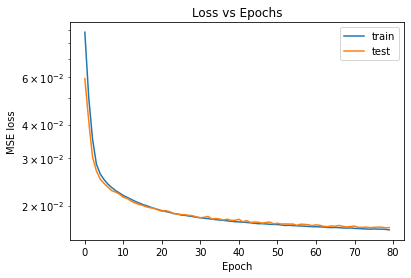

In [32]:
plt.plot(np.array(tr_loss), label = 'train')
plt.plot(np.array(valid_loss), label = 'test')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Loss vs Epochs')
plt.yscale('log')
plt.legend()
plt.show()

In [33]:
# Save network parameters
torch.save(best_encoder.state_dict(), 'best_encoder_params.pth')
torch.save(best_decoder.state_dict(), 'best_decoder_params.pth')

In [34]:
# Load network parameters
best_encoder.load_state_dict(torch.load('best_encoder_params.pth'))
best_decoder.load_state_dict(torch.load('best_decoder_params.pth'))

<All keys matched successfully>

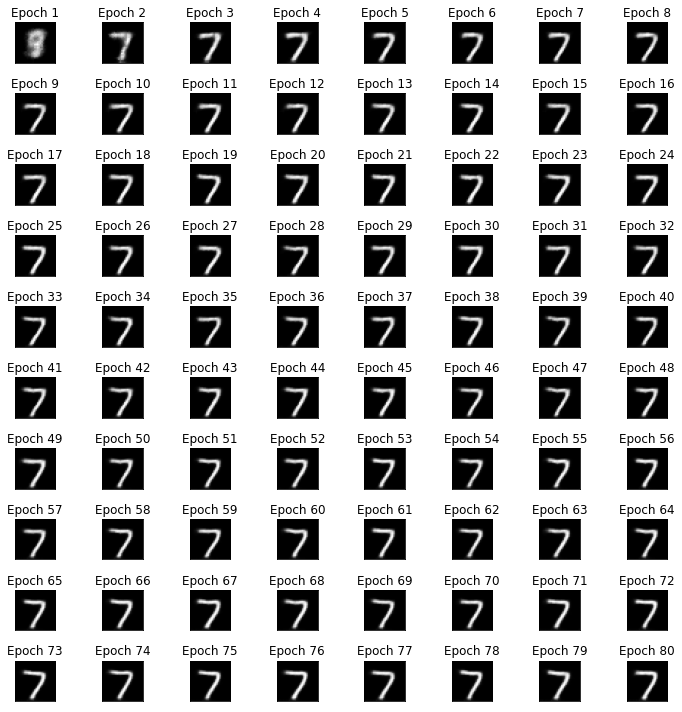

In [35]:
plot_array_rec_images(rec_img_list)

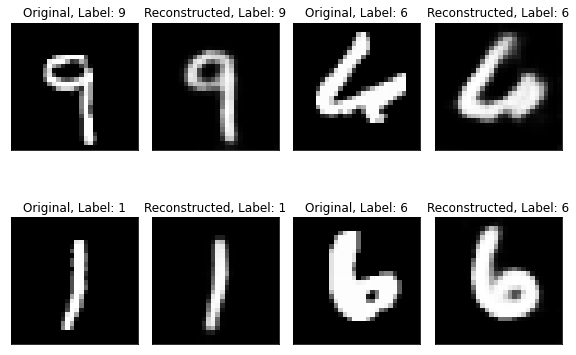

In [36]:
### Plot some samples from test set
fig, axs = plt.subplots(2, 4, figsize=(8,6))

for ax in axs:
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = best_encoder(img.unsqueeze(0).to(device))
        decoded_img  = best_decoder(encoded_img)
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = best_encoder(img.unsqueeze(0).to(device))
        decoded_img  = best_decoder(encoded_img)
    
    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    
plt.tight_layout()

### Explore the latent space

In [37]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = best_encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -2.409570       -11.417003       -14.098976         6.656309   
1           -1.155041        27.004808        -1.725196        -0.416473   
2          -16.634483         3.236464        -1.088877        -0.855772   
3            9.696784         5.428903         1.957031        -6.522435   
4            6.112647        -4.726404        -8.050254         6.281741   
...               ...              ...              ...              ...   
9995        -0.732613        26.078976         5.050899        10.509610   
9996        -3.882351        25.709410        -8.697008       -10.862455   
9997       -13.127224        -7.857661        -5.605815        11.045661   
9998         1.960170        -3.988814         6.579973       -24.659550   
9999        14.899208         6.450779         6.007438       -11.412958   

      Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  label  
0            1.954035         3.148789       -17.734159      7  
1           -2.645282        11.457464        -1.325688      2  
2          -13.697379         7.287082        -4.332894      1  
3           -8.009483       -28.045841         1.601077      0  
4          -14.589042       -14.370175        -3.344025      4  
...               ...              ...              ...    ...  
9995        -2.828546         1.069081       -21.569122      2  
9996         7.985188        -7.039593         6.512976      3  
9997       -20.279045       -16.813017       -11.223804      4  
9998        -6.901465         2.053736       -12.674627      5  
9999       -18.756767       -10.972393        12.655376      6  

[10000 rows x 8 columns]

Let us use the PCA to project the latent space (8-dim) to a 2-dim space which can be more easily represented

In [38]:
from sklearn.decomposition import PCA

pca_encoded          = PCA(n_components = 2)
pca_data             = pca_encoded.fit_transform(encoded_samples.iloc[:,0:-1])
pca_data_df          = pd.DataFrame(data = pca_data, columns = ['var1', 'var2'])
pca_data_df['label'] = encoded_samples.loc[:,'label']
pca_data_df

var1       var2  label
0     19.482428  -0.403390      7
1    -10.331411 -23.217384      2
2     11.076323 -15.636219      1
3    -15.000015  19.174568      0
4      7.871803  15.490295      4
...         ...        ...    ...
9995  -3.840747 -16.807442      2
9996 -22.264576 -14.000930      3
9997  20.588196   8.676446      4
9998  -3.146619  -2.838873      5
9999 -15.332407  12.656794      6

[10000 rows x 3 columns]

In [39]:
import plotly.express as px

px.scatter(pca_data_df, x='var1', y='var2', color=pca_data_df.label.astype(str), opacity=0.7)

Let us now try to use TSNE to clusterize sample and then project onto a 2-dim space

In [40]:
from sklearn import manifold 

tsne = manifold.TSNE(n_components = 2)
tsne.fit(encoded_samples.iloc[:,0:-1])
columns = [ f'Enc. Variable {i}' for i in range(2)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples.iloc[:,0:-1]), columns=columns )
compressed_samples['label'] = encoded_samples.loc[:,'label']

px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=compressed_samples.label.astype(str), opacity=0.7)

### Generate new samples

In [41]:
def generate_samples(n_samples, model, n_dim):
    best_decoder.eval()
    
    img_list = []
    
    for sample in range(n_samples):
        
        sample_generated = np.random.randint(-20, 20, size = (n_dim))
        #use it as "encoded" data
        encoded_generated = torch.tensor(sample_generated).float().unsqueeze(0).to(device)
        #and now decode it
        # Decode sample
        model.eval()
        with torch.no_grad():
            decoded_generated  = model(encoded_generated)
        img_list.append(decoded_generated.squeeze().cpu().numpy())    
    
    #same code as above to generate samples
    n_cols = 5
    
    if n_samples%n_cols == 0:
        n_rows = n_samples//n_cols
    else:
        n_rows = n_samples//n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize = (8, 8))
    for i, img in enumerate(img_list):
        row = i//n_cols
        col = i%n_cols
        ax[row,col].imshow(img, cmap='gist_gray')
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title("Sample "+str(i+1))
    
    plt.tight_layout()
    plt.show()    
        
    return

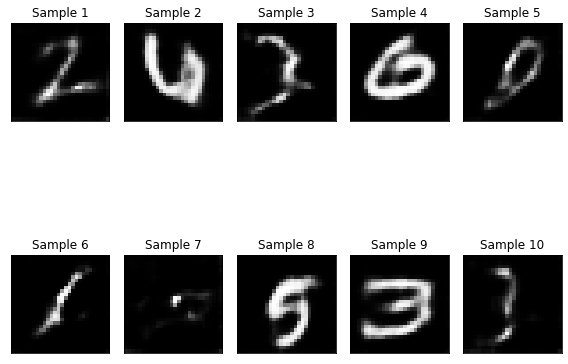

In [42]:
generate_samples(10, best_decoder, opt_network_dictionary.get('encoded_space_dim'))

## Fine tuning

Let us try now to create a classifier for supervised tasks, and find some best hyperparameters thanks to optuna.

In [43]:
class Classifier(nn.Module):
    
    def __init__(self, encoded_space_dim = 2, n_hidden = 100, p_drop = 0.2):
        super().__init__()

        #Network architecture related code
        self.input = nn.Linear(in_features=encoded_space_dim, out_features=n_hidden)
        self.out = nn.Linear(in_features=n_hidden, out_features=10)
        
        #Activation function related code 
        self.act = nn.ReLU()

        #Dropout related code
        self.drop = nn.Dropout(p = p_drop)

    def forward(self, x):
        #first hidden layer related code
        x = self.act(self.input(x))
        x = self.drop(x)
        #output layer
        out = self.out(x)

        return out

In [44]:
def Optuna_create_model_classifier(trial, best_set_parameters):
    
    n_hidden = trial.suggest_int("n_hidden",   25, 1000)
    p_drop   = trial.suggest_float("p_drop", 0.0, 0.5)
    
    encoder = Encoder(encoded_space_dim = opt_network_dictionary.get('encoded_space_dim'), 
                      n_channels        = opt_network_dictionary.get('n_channels'))
    
    classifier = Classifier(encoded_space_dim = opt_network_dictionary.get('encoded_space_dim'), 
                            n_hidden          = n_hidden, 
                            p_drop            = p_drop )
    
    return encoder, classifier

In [45]:
MAX_EPOCHS = 40

### Define the loss function
loss_fn_class = torch.nn.CrossEntropyLoss()

def objective_classifier(trial):

    # Generate the model.
    encoder, classifier = Optuna_create_model_classifier(trial, opt_network_dictionary)
    encoder.to(device)
    classifier.to(device)
    
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) 
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e0, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(classifier.parameters(), lr=lr, weight_decay = weight_decay )

    # Get the dataset.
    train_loader, valid_loader = train_dataloader, validation_dataloader

    # Training of the model.
    for epoch in tqdm(range(MAX_EPOCHS)):
        
        ############################# TRAINING STEP ###################################
        
        # Set train mode only for the classifier
        encoder.eval()
        classifier.train()

        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for image_batch, label in train_loader: 
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            encoded = encoder(image_batch)
            output = classifier(encoded)
            
            # Evaluate loss
            optimizer.zero_grad()
            loss = loss_fn_class(output, label)
            # Backward pass
            loss.backward()
            optimizer.step()
        
        ############################# VALIDATION STEP ###################################
        
        # Set evaluation mode
        encoder.eval()
        classifier.eval()
        
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_out = []
            conc_label = []
            
            for image_batch, label in valid_loader:
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                encoded = encoder(image_batch)
                output = classifier(encoded)

                # Append the network output and the original image to the lists
                conc_out.append(output)
                conc_label.append(label)

            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
            # Evaluate global loss
            val_loss = loss_fn_class(conc_out, conc_label)
        
        trial.report(val_loss.data, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

In [46]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())

[I 2021-08-31 05:30:29,882] A new study created in memory with name: no-name-7a0798e0-e3a8-43b9-b938-74c44861ed5d


In [47]:
study.optimize(objective_classifier, n_trials = 50)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

[I 2021-08-31 05:34:18,963] Trial 0 finished with value: 2.308241128921509 and parameters: {'n_hidden': 785, 'p_drop': 0.03945708444233531, 'optimizer': 'SGD', 'lr': 1.1306762009736507e-05, 'weight_decay': 0.1424682168050255}. Best is trial 0 with value: 2.308241128921509.


[I 2021-08-31 05:38:30,067] Trial 1 finished with value: 2.023117780685425 and parameters: {'n_hidden': 846, 'p_drop': 0.2675891828437219, 'optimizer': 'Adam', 'lr': 0.0145093200743596, 'weight_decay': 0.00022155753441814973}. Best is trial 1 with value: 2.023117780685425.


[I 2021-08-31 05:42:20,716] Trial 2 finished with value: 2.295078992843628 and parameters: {'n_hidden': 864, 'p_drop': 0.02651751728541496, 'optimizer': 'SGD', 'lr': 0.034234440169195385, 'weight_decay': 0.00035047451854765976}. Best is trial 1 with value: 2.023117780685425.


[I 2021-08-31 05:46:24,842] Trial 3 finished with value: 2.3043320178985596 and parameters: {'n_hidden': 454, 'p_drop': 0.3255668923296128, 'optimizer': 'RMSprop', 'lr': 0.04129553504584988, 'weight_decay': 0.0021540202122612246}. Best is trial 1 with value: 2.023117780685425.


[I 2021-08-31 05:50:30,822] Trial 4 finished with value: 1.8496730327606201 and parameters: {'n_hidden': 516, 'p_drop': 0.32688523299558236, 'optimizer': 'RMSprop', 'lr': 0.0004419920242695503, 'weight_decay': 1.3196619215927869e-05}. Best is trial 4 with value: 1.8496730327606201.


[I 2021-08-31 05:50:36,716] Trial 5 pruned. 


[I 2021-08-31 05:50:42,804] Trial 6 pruned. 


[I 2021-08-31 05:51:00,400] Trial 7 pruned. 


[I 2021-08-31 05:51:06,088] Trial 8 pruned. 


[I 2021-08-31 05:51:11,860] Trial 9 pruned. 


[I 2021-08-31 05:55:00,036] Trial 10 finished with value: 2.0565054416656494 and parameters: {'n_hidden': 84, 'p_drop': 0.49308780964009147, 'optimizer': 'RMSprop', 'lr': 0.00027288062789087436, 'weight_decay': 1.2268441659902634e-05}. Best is trial 4 with value: 1.8496730327606201.


[I 2021-08-31 05:59:16,620] Trial 11 finished with value: 1.8218944072723389 and parameters: {'n_hidden': 974, 'p_drop': 0.17480321984185293, 'optimizer': 'Adam', 'lr': 0.0006445776061449768, 'weight_decay': 1.0770990876577124e-05}. Best is trial 11 with value: 1.8218944072723389.


[I 2021-08-31 06:03:32,708] Trial 12 finished with value: 1.6677826642990112 and parameters: {'n_hidden': 981, 'p_drop': 0.15946313573431614, 'optimizer': 'Adam', 'lr': 0.0005773120070251582, 'weight_decay': 1.0256000929825676e-05}. Best is trial 12 with value: 1.6677826642990112.


[I 2021-08-31 06:03:38,753] Trial 13 pruned. 


[I 2021-08-31 06:03:44,965] Trial 14 pruned. 


[I 2021-08-31 06:08:03,432] Trial 15 finished with value: 1.7884275913238525 and parameters: {'n_hidden': 964, 'p_drop': 0.10931135745778064, 'optimizer': 'Adam', 'lr': 0.0025391565124316478, 'weight_decay': 6.870693429088584e-05}. Best is trial 12 with value: 1.6677826642990112.


[I 2021-08-31 06:12:15,196] Trial 16 finished with value: 1.6352415084838867 and parameters: {'n_hidden': 928, 'p_drop': 0.10425760160862153, 'optimizer': 'Adam', 'lr': 0.0018386436094367427, 'weight_decay': 5.807497541622753e-05}. Best is trial 16 with value: 1.6352415084838867.


[I 2021-08-31 06:12:21,115] Trial 17 pruned. 


[I 2021-08-31 06:12:27,077] Trial 18 pruned. 


[I 2021-08-31 06:16:31,102] Trial 19 finished with value: 1.805145502090454 and parameters: {'n_hidden': 693, 'p_drop': 0.09787688992418846, 'optimizer': 'Adam', 'lr': 0.0010390796626839104, 'weight_decay': 2.6297296796999086e-05}. Best is trial 16 with value: 1.6352415084838867.


[I 2021-08-31 06:16:36,768] Trial 20 pruned. 


[I 2021-08-31 06:20:09,453] Trial 21 pruned. 


[I 2021-08-31 06:24:43,869] Trial 22 finished with value: 1.6909791231155396 and parameters: {'n_hidden': 898, 'p_drop': 0.11213321051429617, 'optimizer': 'Adam', 'lr': 0.0017974787882099235, 'weight_decay': 3.299559396528575e-05}. Best is trial 16 with value: 1.6352415084838867.


[I 2021-08-31 06:29:19,173] Trial 23 finished with value: 1.6580418348312378 and parameters: {'n_hidden': 885, 'p_drop': 0.06909051981236095, 'optimizer': 'Adam', 'lr': 0.006314900636568669, 'weight_decay': 2.6691896406105237e-05}. Best is trial 16 with value: 1.6352415084838867.


[I 2021-08-31 06:33:57,847] Trial 24 finished with value: 1.7840728759765625 and parameters: {'n_hidden': 895, 'p_drop': 0.06579272057577601, 'optimizer': 'Adam', 'lr': 0.007738323427538631, 'weight_decay': 2.5165698748011492e-05}. Best is trial 16 with value: 1.6352415084838867.


[I 2021-08-31 06:34:04,188] Trial 25 pruned. 


[I 2021-08-31 06:38:40,399] Trial 26 finished with value: 1.7147293090820312 and parameters: {'n_hidden': 591, 'p_drop': 0.06558950815304271, 'optimizer': 'Adam', 'lr': 0.0828522889505428, 'weight_decay': 2.671860760008977e-05}. Best is trial 16 with value: 1.6352415084838867.


[I 2021-08-31 06:43:03,827] Trial 27 finished with value: 1.7298567295074463 and parameters: {'n_hidden': 431, 'p_drop': 0.139966520782223, 'optimizer': 'Adam', 'lr': 0.007236667165031228, 'weight_decay': 1.0740535759831355e-05}. Best is trial 16 with value: 1.6352415084838867.


[I 2021-08-31 06:43:10,221] Trial 28 pruned. 


[I 2021-08-31 06:43:16,859] Trial 29 pruned. 


[I 2021-08-31 06:43:23,284] Trial 30 pruned. 


[I 2021-08-31 06:43:29,805] Trial 31 pruned. 


[I 2021-08-31 06:44:59,096] Trial 32 pruned. 


[I 2021-08-31 06:49:48,111] Trial 33 finished with value: 1.7273626327514648 and parameters: {'n_hidden': 862, 'p_drop': 0.004427917205427748, 'optimizer': 'Adam', 'lr': 0.005730209305213799, 'weight_decay': 4.050319313109194e-05}. Best is trial 16 with value: 1.6352415084838867.


[I 2021-08-31 06:50:00,519] Trial 34 pruned. 


[I 2021-08-31 06:50:06,831] Trial 35 pruned. 


[I 2021-08-31 06:50:12,909] Trial 36 pruned. 


[I 2021-08-31 06:50:19,063] Trial 37 pruned. 


[I 2021-08-31 06:50:25,206] Trial 38 pruned. 


[I 2021-08-31 06:50:31,403] Trial 39 pruned. 


[I 2021-08-31 06:50:37,507] Trial 40 pruned. 


[I 2021-08-31 06:50:43,593] Trial 41 pruned. 


[I 2021-08-31 06:50:49,581] Trial 42 pruned. 


[I 2021-08-31 06:50:55,586] Trial 43 pruned. 


[I 2021-08-31 06:51:01,935] Trial 44 pruned. 


[I 2021-08-31 06:51:07,834] Trial 45 pruned. 


[I 2021-08-31 06:51:13,980] Trial 46 pruned. 


[I 2021-08-31 06:51:19,979] Trial 47 pruned. 


[I 2021-08-31 06:51:26,177] Trial 48 pruned. 


[I 2021-08-31 06:51:58,631] Trial 49 pruned. 



Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  33
  Number of complete trials:  17


In [48]:
optuna.visualization.plot_optimization_history(study, target_name = 'Validation loss' )

In [49]:
optuna.visualization.plot_intermediate_values(study)

In [50]:
optuna.visualization.plot_parallel_coordinate(study, target_name = 'Validation loss' )

In [51]:
optimization_dir = 'optimization_finetuning'
pathlib.Path(optimization_dir).mkdir(parents=True, exist_ok=True) 

trials_df = study.trials_dataframe()
trials_df.to_csv(optimization_dir + '/optuna_results.csv')

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
fine_opt_network_dictionary = {}
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value)) 
    fine_opt_network_dictionary.update({key:value})
trials_df

Best trial:
  Value:  1.6352415084838867
  Params: 
    n_hidden: 928
    p_drop: 0.10425760160862153
    optimizer: Adam
    lr: 0.0018386436094367427
    weight_decay: 5.807497541622753e-05


number     value             datetime_start          datetime_complete  \
0        0  2.308241 2021-08-31 05:30:29.890638 2021-08-31 05:34:18.963498   
1        1  2.023118 2021-08-31 05:34:18.964791 2021-08-31 05:38:30.067247   
2        2  2.295079 2021-08-31 05:38:30.068576 2021-08-31 05:42:20.715674   
3        3  2.304332 2021-08-31 05:42:20.717004 2021-08-31 05:46:24.841688   
4        4  1.849673 2021-08-31 05:46:24.842924 2021-08-31 05:50:30.822207   
5        5  2.305414 2021-08-31 05:50:30.823541 2021-08-31 05:50:36.716323   
6        6  2.309779 2021-08-31 05:50:36.717146 2021-08-31 05:50:42.804902   
7        7  2.302133 2021-08-31 05:50:42.805695 2021-08-31 05:51:00.400473   
8        8  2.302428 2021-08-31 05:51:00.401995 2021-08-31 05:51:06.088419   
9        9  2.311851 2021-08-31 05:51:06.089300 2021-08-31 05:51:11.860385   
10      10  2.056505 2021-08-31 05:51:11.862103 2021-08-31 05:55:00.036047   
11      11  1.821894 2021-08-31 05:55:00.038394 2021-08-31 05:59:16.620052   
12      12  1.667783 2021-08-31 05:59:16.621341 2021-08-31 06:03:32.708096   
13      13  2.301302 2021-08-31 06:03:32.709391 2021-08-31 06:03:38.753916   
14      14  2.302078 2021-08-31 06:03:38.754716 2021-08-31 06:03:44.965493   
15      15  1.788428 2021-08-31 06:03:44.966288 2021-08-31 06:08:03.432485   
16      16  1.635242 2021-08-31 06:08:03.434841 2021-08-31 06:12:15.195707   
17      17  2.301201 2021-08-31 06:12:15.196982 2021-08-31 06:12:21.115586   
18      18  2.301877 2021-08-31 06:12:21.116416 2021-08-31 06:12:27.077640   
19      19  1.805146 2021-08-31 06:12:27.078459 2021-08-31 06:16:31.102287   
20      20  2.306790 2021-08-31 06:16:31.103582 2021-08-31 06:16:36.768927   
21      21  1.898751 2021-08-31 06:16:36.769788 2021-08-31 06:20:09.453423   
22      22  1.690979 2021-08-31 06:20:09.454249 2021-08-31 06:24:43.868566   
23      23  1.658042 2021-08-31 06:24:43.869977 2021-08-31 06:29:19.173420   
24      24  1.784073 2021-08-31 06:29:19.174734 2021-08-31 06:33:57.847277   
25      25  2.299348 2021-08-31 06:33:57.849102 2021-08-31 06:34:04.188367   
26      26  1.714729 2021-08-31 06:34:04.189297 2021-08-31 06:38:40.399215   
27      27  1.729857 2021-08-31 06:38:40.400530 2021-08-31 06:43:03.827546   
28      28  2.303093 2021-08-31 06:43:03.828828 2021-08-31 06:43:10.221681   
29      29  2.303376 2021-08-31 06:43:10.222489 2021-08-31 06:43:16.859157   
30      30  2.302350 2021-08-31 06:43:16.860235 2021-08-31 06:43:23.284288   
31      31  2.298166 2021-08-31 06:43:23.285196 2021-08-31 06:43:29.805516   
32      32  1.960725 2021-08-31 06:43:29.806885 2021-08-31 06:44:59.096423   
33      33  1.727363 2021-08-31 06:44:59.097562 2021-08-31 06:49:48.110673   
34      34  2.278152 2021-08-31 06:49:48.112214 2021-08-31 06:50:00.519028   
35      35  2.297750 2021-08-31 06:50:00.519901 2021-08-31 06:50:06.831149   
36      36  2.302507 2021-08-31 06:50:06.832105 2021-08-31 06:50:12.909809   
37      37  2.319721 2021-08-31 06:50:12.910649 2021-08-31 06:50:19.063518   
38      38  2.302329 2021-08-31 06:50:19.064453 2021-08-31 06:50:25.206553   
39      39  2.304325 2021-08-31 06:50:25.207920 2021-08-31 06:50:31.403295   
40      40  2.302146 2021-08-31 06:50:31.404213 2021-08-31 06:50:37.507251   
41      41  2.302391 2021-08-31 06:50:37.508855 2021-08-31 06:50:43.593298   
42      42  2.310935 2021-08-31 06:50:43.594188 2021-08-31 06:50:49.581933   
43      43  2.305533 2021-08-31 06:50:49.582751 2021-08-31 06:50:55.586018   
44      44  2.299572 2021-08-31 06:50:55.586973 2021-08-31 06:51:01.935319   
45      45  2.304427 2021-08-31 06:51:01.936965 2021-08-31 06:51:07.834928   
46      46  2.302094 2021-08-31 06:51:07.835858 2021-08-31 06:51:13.980148   
47      47  2.301345 2021-08-31 06:51:13.981120 2021-08-31 06:51:19.979910   
48      48  2.301827 2021-08-31 06:51:19.980918 2021-08-31 06:51:26.177845   
49      49  2.168382 2021-08-31 06:51:26.178667 2021-08-31 06:51:58.631773   

                 duration

In [52]:
fine_opt_network_dictionary

{'n_hidden': 928,
 'p_drop': 0.10425760160862153,
 'optimizer': 'Adam',
 'lr': 0.0018386436094367427,
 'weight_decay': 5.807497541622753e-05}

In [52]:
fine_opt_network_dictionary

{'n_hidden': 928,
 'p_drop': 0.10425760160862153,
 'optimizer': 'Adam',
 'lr': 0.0018386436094367427,
 'weight_decay': 5.807497541622753e-05}

In [53]:
def training_class(encoder, classifier, train_loader, valid_loader, params_dict, save_checkpoint = False):

        
    valid_losses_list = []
    train_losses_list = []
    
    optim      = params_dict.get('optimizer')
    loss       = params_dict.get('loss')
    
    
    for epoch in tqdm(range(params_dict.get('n_epochs'))):

        ############################# TRAINING STEP ###################################
        
        # Set train mode only for the classifier
        encoder.eval()
        classifier.train()

        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for image_batch, label in train_loader: 
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            encoded = encoder(image_batch)
            output = classifier(encoded)
            
            # Evaluate loss
            optim.zero_grad()
            loss = loss_fn_class(output, label)
            # Backward pass
            loss.backward()
            optim.step()
        
        ############################# VALIDATION STEP ###################################
        
        # Set evaluation mode
        encoder.eval()
        classifier.eval()
        
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_out = []
            conc_label = []
            
            for image_batch, label in valid_loader:
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                encoded = encoder(image_batch)
                output = classifier(encoded)

                # Append the network output and the original image to the lists
                conc_out.append(output)
                conc_label.append(label)

            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
            # Evaluate global loss
            val_loss = loss_fn_class(conc_out, conc_label)

        if (save_checkpoint):
            # Save network parameters
            torch.save(decoder.state_dict(),   'classifier_params.pth')
            torch.save(optim.state_dict(),     'fine_optim_params.pth')
            
        train_losses_list.append(loss.data)
        valid_losses_list.append(val_loss.data)

    return train_losses_list, valid_losses_list


In [54]:
def predict(encoder, classifier, data_input, device):
    '''
    Compute an array of predicted labels given input data
    '''
    #set evaluation mode
    encoder.eval()
    classifier.eval()
    
    predictions_list = []

    #disable gradient computing/tracking
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(data_input):
            x_batch = sample_batched[0].to(device) 
            #Forward pass
            encoded = encoder.forward(x_batch)
            out = classifier.forward(encoded)
            outputs = out.cpu().numpy().argmax()

            predictions_list.append(outputs)
    return np.array( predictions_list )

def test(encoder, classifier, test_loader, device):
        '''
        Test the network in a classification task
        '''
        wrong_label = 0
        predictions = []
        true_labels = []

        encoder.eval()
        classifier.eval()
        
        # Disable gradient tracking
        with torch.no_grad():
            for sample_batched in test_loader:
                #divide the batch into values and labels
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                #Forward pass
                encoded = encoder.forward(x_batch)
                out = classifier(encoded)
                out = out.cpu().numpy().argmax()

                predictions.append(out)
                true_labels.append(label_batch)
                
        num_samples = len(test_loader)
        temp_list = [predictions[i]-true_labels[i] for i in range(num_samples)]
        #"zero" elements are the correct ones
        accuracy = temp_list.count(0)/num_samples
        return accuracy

In [55]:
best_classif = Classifier(encoded_space_dim = opt_network_dictionary.get('encoded_space_dim'),
                          n_hidden          = fine_opt_network_dictionary.get('n_hidden'),
                          p_drop            = fine_opt_network_dictionary.get('p_drop')
                         )

### Define the loss function
loss_fn_class = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': best_classif.parameters()}
]
optim = get_correct_optimizer(params_to_optimize, fine_opt_network_dictionary)

def_params_dict = {
    "device"    : device,
    "n_epochs"  : 80,
    "loss"      : loss_fn_class,
    "optimizer" : optim,
}


# Move both the encoder and the decoder to the selected device
best_encoder.to(device)
best_classif.to(device)

Classifier(
  (input): Linear(in_features=7, out_features=928, bias=True)
  (out): Linear(in_features=928, out_features=10, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.10425760160862153, inplace=False)
)

In [56]:
tr_loss, valid_loss = training_class(best_encoder, best_classif, train_dataloader, test_dataloader, def_params_dict, save_checkpoint = True)

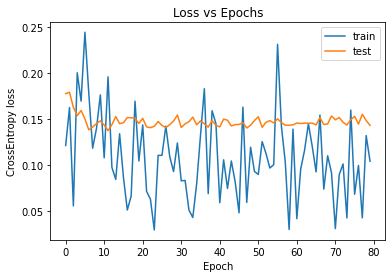

In [57]:
plt.plot(np.array(tr_loss), label = 'train')
plt.plot(np.array(valid_loss), label = 'test')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

#### Results analysis

Labels and frequencies in test set:  [ 980 1135 1032 1010  982  892  958 1028  974 1009]

 Confusion matrix (normalized)


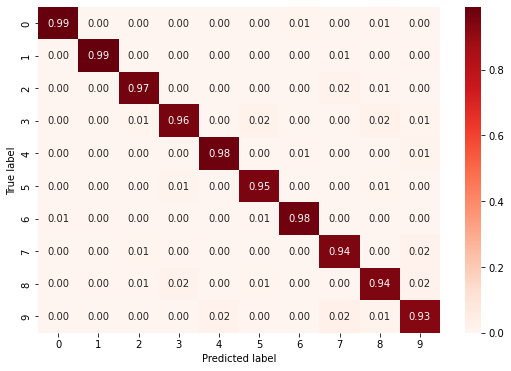

Model accuracy is:  0.9631


In [66]:
import seaborn as sns
import sklearn.metrics as skm

test_dataloader_predict = DataLoader(test_dataset, batch_size=1, shuffle=False)

#Analyze the predictions with a confusion matrix
predictions = predict(best_encoder, best_classif, test_dataloader_predict, device)
true_labels = np.array([x[1] for x in test_dataset])

# for better aligned printing of confusion matrix use floatmode='fixed' (not supported in all versions of Python)
np.set_printoptions(precision=3, suppress=True, floatmode = 'fixed')

u, counts = np.unique(true_labels, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_test = skm.confusion_matrix( predictions, true_labels)

print("\n Confusion matrix (normalized)")
plt.figure(figsize = (9,6))
sns.heatmap(confusion_test/counts[:,None], annot=True, fmt =  "1.2f" , cmap="Reds" )
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print("Model accuracy is: ", test( best_encoder, best_classif, test_dataloader_predict , device ))

# Denoising autoencoder

In [59]:
class AddGaussianNoise():
    '''
    Add Gaussian noise to an image. 
    Gaussian has mean "mu" and standard deviation "std" 
    '''
    def __init__(self, mu = 0., std = 1., clip = True):
        self.mu   = mu
        self.std  = std
        self.clip = clip

    def __call__(self, tensor):
        perturb    = torch.randn(tensor.size(), device=tensor.device) * self.std
        new_tensor = tensor + perturb + self.mu
        
        if (self.clip):
            return torch.clamp(new_tensor, min = 0., max = 1.)
        else:
            return new_tensor
        
        return 

class AddSaltPepper():
    '''
    Add Salt&Pepper noise to an image.
    p1 is the probability to select a pixel
    p2 is the probability to turn it white, conversely 1-p2 is the probability to turn it black
    '''
    def __init__(self, p1 = 0.05, p2 = 0.50):
        self.p_select_pixel = p1
        self.p_flip         = p2

    def __call__(self, tensor ):
        selected_mask = torch.rand(tensor.size(), device = tensor.device ) < self.p_select_pixel
        whitened_mask = torch.rand(tensor.size(), device = tensor.device ) < self.p_flip
        blacked_mask  = ~whitened_mask
        
        new_tensor = tensor.clone()
        new_tensor[(selected_mask) & (whitened_mask)] = 1. 
        new_tensor[(selected_mask) & (blacked_mask) ] = 0.
        
        return new_tensor

class DummyNoise():
    '''
    Do nothing
    '''
    def __init__(self):
        pass
    def __call__(self, tensor ):
        return tensor


In [60]:
Gaussian    = AddGaussianNoise()
Salt_Pepper = AddSaltPepper(0.2, 0.5)
Dummy_Noise = DummyNoise()

#Transform with both noises
both_noises_transform = transforms.Compose([
    Gaussian,
    Salt_Pepper,
])

#pick a noise or combination of noises from:
# - both noises
# - Gaussian noise
# - Salt&Pepper
# - Nothing
noise_choice_transform = transforms.RandomChoice([ 
    both_noises_transform, 
    Gaussian,
    Salt_Pepper,
    Dummy_Noise
])

#appropriate transform
noise_transform = transforms.Compose([
    transforms.ToTensor(),
    noise_choice_transform
])

In [61]:
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset       = torchvision.datasets.MNIST(data_dir, train = True,  download=True)
train_dataset_noisy = torchvision.datasets.MNIST(data_dir, train = True,  download=True)

test_dataset        = torchvision.datasets.MNIST(data_dir, train = False, download=True)
test_dataset_noisy  = torchvision.datasets.MNIST(data_dir, train = False, download=True)

train_dataset.transform = train_transform
test_dataset.transform  = test_transform
train_dataset_noisy.transform  = noise_transform
test_dataset_noisy.transform   = noise_transform

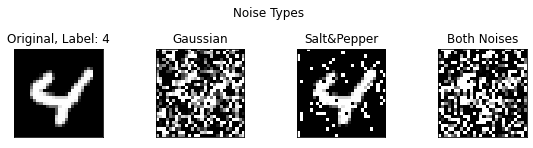

In [62]:
# pick random sample
img, label = random.choice(train_dataset)

noise_gaussian   = AddGaussianNoise(0., 1.)(img)
noise_saltpepper = AddSaltPepper(0.2, 0.5)(img)
noise_all_noises = both_noises_transform(img)

# Plot original img and noisy ones
fig, ax = plt.subplots(1, 4, figsize=(8,2))

ax[0].imshow(np.array(img[0]), cmap='gist_gray')
ax[1].imshow(noise_gaussian.squeeze(0).data.numpy(),   cmap='gist_gray')
ax[2].imshow(noise_saltpepper.squeeze(0).data.numpy(), cmap='gist_gray')
ax[3].imshow(noise_all_noises.squeeze(0).data.numpy(), cmap='gist_gray')

ax[0].set_title('Original, Label: %d' % label)
ax[1].set_title('Gaussian')
ax[2].set_title('Salt&Pepper')
ax[3].set_title('Both Noises') 

for axs in ax:
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_xticklabels([])
    axs.set_yticklabels([])

fig.suptitle("Noise Types", fontsize = 12)
plt.tight_layout()
plt.show()

In [63]:
### Define train dataloader
noisy_train_dataloader = DataLoader(train_dataset_noisy, batch_size=256, shuffle=True)
### Define test dataloader
noisy_test_dataloader  = DataLoader(test_dataset_noisy,  batch_size=256, shuffle=False)

In [64]:
denoiser_encoder = Encoder(encoded_space_dim=opt_network_dictionary.get('encoded_space_dim'),
                       n_channels = opt_network_dictionary.get('n_channels'))
denoiser_decoder = Decoder(encoded_space_dim=opt_network_dictionary.get('encoded_space_dim'),
                       n_channels = opt_network_dictionary.get('n_channels'))

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': denoiser_encoder.parameters()},
    {'params': denoiser_decoder.parameters()}
]
optim = get_correct_optimizer(params_to_optimize, opt_network_dictionary)

dummy_params_dict = {
    "device"    : device,
    "n_epochs"  : 80,
    "loss"      : loss_fn,
    "optimizer" : optim,
}

# Move both the encoder and the decoder to the selected device
denoiser_encoder.to(device)
denoiser_decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=432, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(48, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(24, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(12, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [67]:
tr_loss, valid_loss, rec_img_list = training(denoiser_encoder, denoiser_decoder, 
                                             noisy_train_dataloader, noisy_test_dataloader, 
                                             dummy_params_dict, test_dataset,
                                             plot_progress = False, save_output = True, save_checkpoint = True)

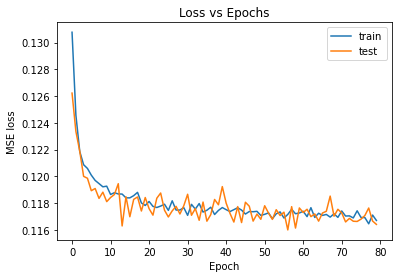

In [68]:
plt.plot(np.array(tr_loss), label = 'train')
plt.plot(np.array(valid_loss), label = 'test')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

In [69]:
# Save network parameters
torch.save(best_encoder.state_dict(), 'denoiser_encoder_params.pth')
torch.save(best_decoder.state_dict(), 'enoiser_decoder_params.pth' )

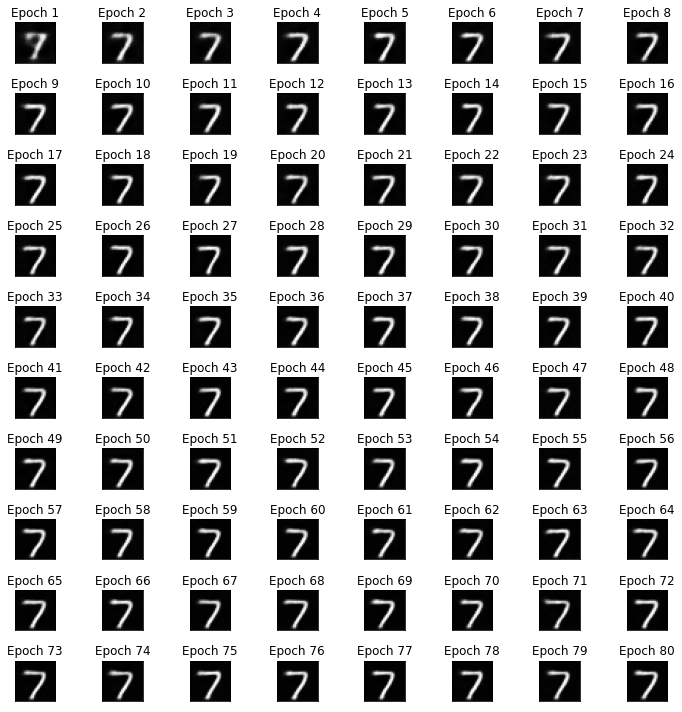

In [70]:
plot_array_rec_images(rec_img_list)

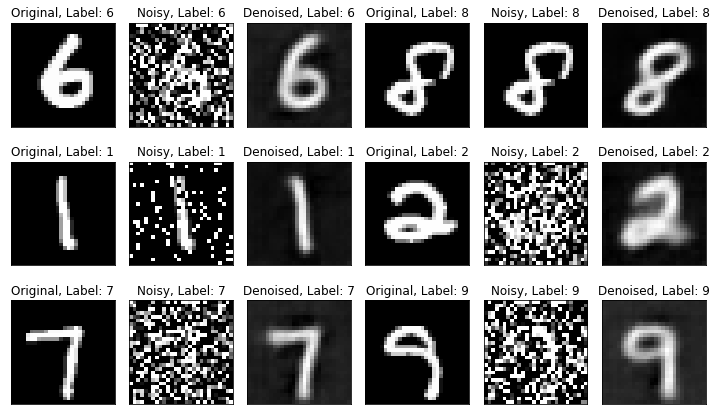

In [71]:
### Plot some sample
fig, axs = plt.subplots(3, 6, figsize=(10,6))
for ax in axs:
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    img = noise_choice_transform(img)
    img1 = img.squeeze(0).data.numpy()
    ax[1].imshow(np.array(img1), cmap='gist_gray')
    ax[1].set_title('Noisy, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img1 = img.unsqueeze(0).to(device)
    best_encoder.eval()
    best_decoder.eval()
    with torch.no_grad():
        encoded_img  = denoiser_encoder(img1)
        decoded_img  = denoiser_decoder(encoded_img)
    ax[2].imshow(np.array(decoded_img.cpu()[0][0]), cmap='gist_gray')
    ax[2].set_title('Denoised, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    ax[3].imshow(np.array(img1), cmap='gist_gray')
    ax[3].set_title('Original, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    img = noise_choice_transform(img)
    img1 = img.squeeze(0).data.numpy()
    ax[4].imshow(np.array(img1), cmap='gist_gray')
    ax[4].set_title('Noisy, Label: %d' % label)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    
    img1 = img.unsqueeze(0).to(device)
    best_encoder.eval()
    best_decoder.eval()
    with torch.no_grad():
        encoded_img  = denoiser_encoder(img1)
        decoded_img  = denoiser_decoder(encoded_img)
    ax[5].imshow(np.array(decoded_img.cpu()[0][0]), cmap='gist_gray')
    ax[5].set_title('Denoised, Label: %d' % label)
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    
plt.tight_layout()

# VAE

In [72]:
class VariationalEncoder(nn.Module):
    def __init__(self, encoded_space_dim = 2, n_channels = 8):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels = 1,  out_channels = n_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(n_channels, 2*n_channels, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(2*n_channels, 4*n_channels, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Latent space layers
        self.means_vector    = nn.Linear(3 * 3 * 4*n_channels, encoded_space_dim)
        self.log_vars_vector = nn.Linear(3 * 3 * 4*n_channels, encoded_space_dim)
        return
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # Apply linear layers
        means    = self.means_vector(x)
        log_vars = self.log_vars_vector(x)
        
        return means, log_vars

In [73]:
class VariationalDecoder(nn.Module):
    
    def __init__(self, encoded_space_dim = 2, n_channels = 8):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 4*n_channels),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(4*n_channels, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(4*n_channels, 2*n_channels, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(2*n_channels, n_channels, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(n_channels, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [74]:
# see https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
import torch.nn.functional as F

class VariationalAutoEncoder(nn.Module):
    
    def __init__(self, params_dict, regKL = 1.):
        super().__init__()
        self.encoder  = VariationalEncoder(params_dict.get('encoded_space_dim'), params_dict.get('n_channels'))
        self.decoder  = VariationalDecoder(params_dict.get('encoded_space_dim'), params_dict.get('n_channels'))
        self.device   = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.lat_dim  = params_dict.get('encoded_space_dim')
        self.regKL    = regKL
        return
    
    def forward(self, x):
        #encode the image and get the mean and log_var
        mean, log_var = self.encoder(x)
        self.mu       = mean
        self.sigma    = torch.exp(0.5*log_var) # standard deviation
        self.log_var  = log_var
        #sample from the latent space
        sample     = self.reparameterize()
        #decode the sampled vector
        out        = self.decoder(sample)
        return out
    
    def reparameterize(self):
        """
        param mu: mean from the encoder's latent space
        param log_var: log variance from the encoder's latent space
        """
        eps    = torch.randn_like(self.sigma)       # `randn_like` as we need the same size
        sample = eps.mul(self.sigma).add_(self.mu)  # sampling as if coming from the input space
        return sample 
    
    def _KL_divergence(self):
        return -0.5*torch.sum( 1 + self.log_var - self.mu.pow(2) - self.sigma.pow(2)  )
    
    
    ### Training function
    def train_epoch(self, dataloader, optimizer):
        
        batches_loss = 0.
        
        # Set train mode
        self.train()
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
            # Move tensor to the proper device
            image_batch = image_batch.to(self.device)
            
            out = self.forward(image_batch)
            
            # Evaluate the reconstruction loss
            accuracy_loss = F.mse_loss(out, image_batch, reduction='sum')
            KL_loss       = self.regKL*self._KL_divergence()
            #the following quantity has to be minimized
            loss = accuracy_loss + torch.absolute(KL_loss)
            batches_loss += KL_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Append the network output and the original image to the lists
            conc_out.append(out.cpu())
            conc_label.append(image_batch.cpu())

        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        train_loss =  F.mse_loss(conc_out, conc_label, reduction='sum')

        #return the training loss
        return (train_loss.data + batches_loss.data)/len(dataloader.dataset)
    
   
    
    ### Testing function
    def test_epoch(self, dataloader):
        batches_loss = 0.
        # Set evaluation mode
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_out = []
            conc_label = []
            for image_batch, _ in dataloader:
                # Move tensor to the proper device
                image_batch = image_batch.to(self.device)
                # Decode data
                out = self.forward(image_batch)
                
                # Evaluate the reconstruction loss
                accuracy_loss = F.mse_loss(out, image_batch, reduction='sum')
                KL_loss       = self.regKL*self._KL_divergence()
                #the following quantity has to be minimized
                loss = accuracy_loss + torch.absolute(KL_loss)
                batches_loss += KL_loss
                
                # Append the network output and the original image to the lists
                conc_out.append(out.cpu())
                conc_label.append(image_batch.cpu())

            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
            # Evaluate global loss
            val_loss = F.mse_loss(conc_out, conc_label, reduction='sum')

        return (val_loss.data + batches_loss.data)/len(dataloader.dataset)
    
    ### Testing function
    def fit(self, train_dataloader, validate_dataloader, optimizer, n_epochs = 40, show_progress = False, test_dataset = None):
        
        train_loss_log = []
        val_loss_log   = []
        
        for epoch in tqdm(range(n_epochs)):
            train_loss = self.train_epoch(train_dataloader, optimizer)
            valid_loss = self.test_epoch(validate_dataloader)
            
            train_loss_log.append(train_loss)
            val_loss_log.append(valid_loss)
            
            if (show_progress):
                img = test_dataset[0][0].unsqueeze(0).to(self.device)
                
                self.eval()
                with torch.no_grad():
                    rec_img  = self.forward(img)

                # Plot the reconstructed image
                fig, axs = plt.subplots(1, 2, figsize=(8,4))
                axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
                axs[0].set_title('Original image')
                axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
                axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
                plt.tight_layout()
                plt.show()
                    
        return train_loss_log, val_loss_log
    
    def plot_reconstructed(self, r0 = (-5, 10), r1 = (-10, 5), n = 12, figsize = (6,6)):
        if (self.lat_dim == 2): 
            #ref https://avandekleut.github.io/vae/
            w = 28
            img = np.zeros((n*w, n*w))
            for i, y in enumerate(np.linspace(*r1, n)):
                for j, x in enumerate(np.linspace(*r0, n)):
                    z = torch.Tensor([[x, y]]).to(device)
                    x_hat = self.decoder(z)
                    x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
                    img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
            plt.figure(figsize = figsize)
            plt.imshow(img, extent=[*r0, *r1])
        else:
            print("Latent space must be of dim 2!")
        return
        

In [75]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define validation dataloader
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [76]:
dummy_dict = {'encoded_space_dim' : 2, 'n_channels' : 12}
VAE = VariationalAutoEncoder(dummy_dict)
VAE

VariationalAutoEncoder(
  (encoder): VariationalEncoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (means_vector): Linear(in_features=432, out_features=2, bias=True)
    (log_vars_vector): Linear(in_features=432, out_features=2, bias=True)
  )
  (decoder): VariationalDecoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=432, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(48, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(48, 24, kernel_size=(3, 3), s

In [77]:
### Define an optimizer
params_to_optimize = [
    {'params': VAE.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr =  1e-3, weight_decay = 1e-5)
# optim = get_correct_optimizer(params_to_optimize, opt_network_dictionary)
 
tr_loss, val_loss = VAE.fit(train_dataloader, validation_dataloader, optim, 20)

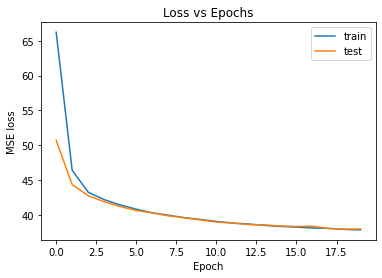

In [78]:
plt.plot(np.array(tr_loss), label = 'train')
plt.plot(np.array(val_loss), label = 'test')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

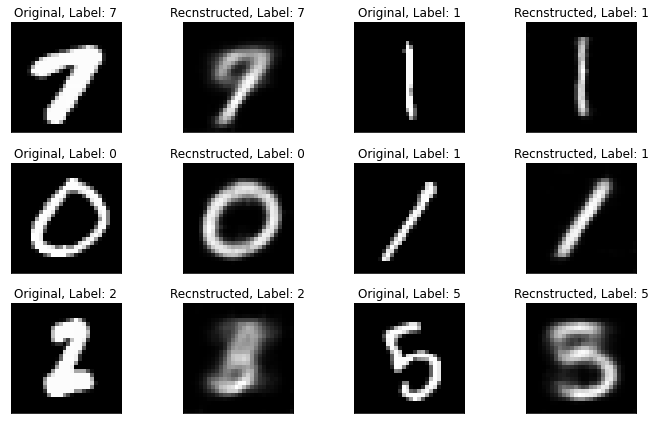

In [79]:
### Plot some sample
fig, axs = plt.subplots(3, 4, figsize=(10,6))
for ax in axs:
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    img1 = img.unsqueeze(0).to(device)
    VAE.eval()
    with torch.no_grad():
        reconstructed = VAE(img1)
    ax[1].imshow(np.array(reconstructed.cpu()[0][0]), cmap='gist_gray')
    ax[1].set_title('Recnstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    img1 = img.unsqueeze(0).to(device)
    VAE.eval()
    with torch.no_grad():
        reconstructed = VAE(img1)
    ax[3].imshow(np.array(reconstructed.cpu()[0][0]), cmap='gist_gray')
    ax[3].set_title('Recnstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
plt.tight_layout()

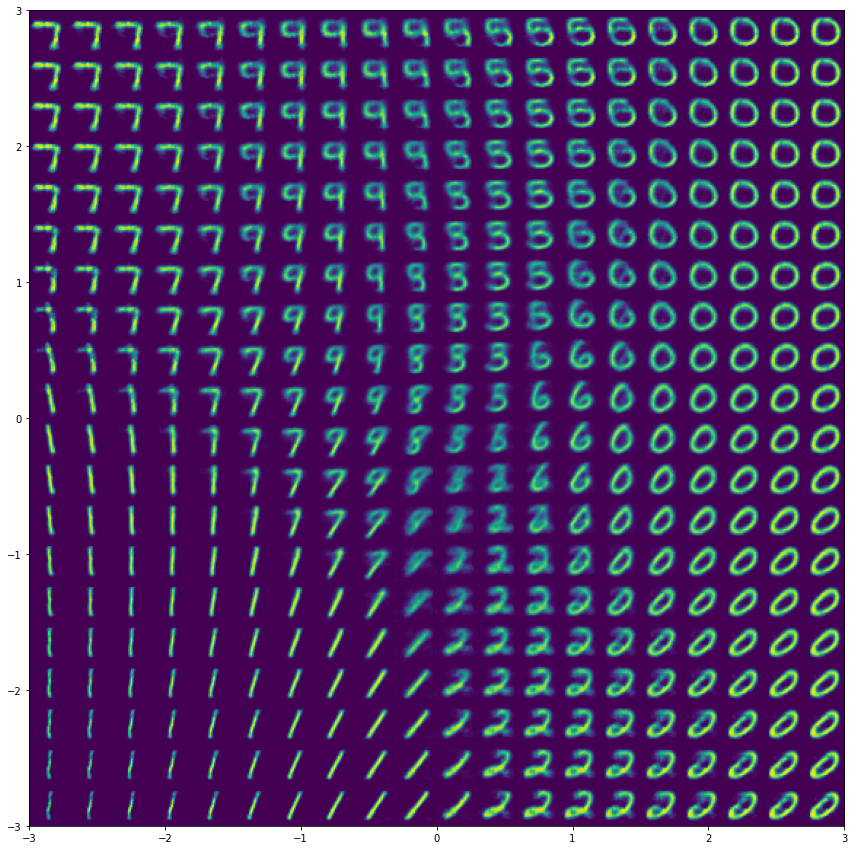

In [80]:
VAE.plot_reconstructed( r0=(-3, 3), r1=(-3, 3) , n= 20, figsize = (15,15))